In [15]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Define a Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size=3, hidden_size=20, output_size=1, depth=4):
        super(SimpleNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(depth):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Step 2: Define the Physics-Informed Neural Network (PINN)
class PINN:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN(input_size=3).to(self.device)  # Input: x, y, t
        
        # Spatial and temporal discretization
        self.h = 0.05  # space step
        self.k = 0.05  # time step
        self.alpha = 0.01  # thermal diffusivity constant
        
        # Create 2D spatial grid and time points
        x = torch.arange(-1, 1 + self.h, self.h)
        y = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 5 + self.k, self.k)
        
        # Create full 3D grid (x, y, t)
        X, Y, T = torch.meshgrid(x, y, t, indexing='ij')
        self.X = torch.stack([X.flatten(), Y.flatten(), T.flatten()], dim=1).to(self.device)
        
        # Boundary conditions (all sides at x=-1, x=1, y=-1, y=1)
        # Need to create proper meshgrids for each boundary
        Y_bc, T_bc = torch.meshgrid(y, t, indexing='ij')
        bc1 = torch.stack([torch.full_like(Y_bc, -1), Y_bc, T_bc], dim=-1).reshape(-1, 3)  # x=-1 boundary
        bc2 = torch.stack([torch.full_like(Y_bc, 1), Y_bc, T_bc], dim=-1).reshape(-1, 3)   # x=1 boundary
        
        X_bc, T_bc = torch.meshgrid(x, t, indexing='ij')
        bc3 = torch.stack([X_bc, torch.full_like(X_bc, -1), T_bc], dim=-1).reshape(-1, 3)  # y=-1 boundary
        bc4 = torch.stack([X_bc, torch.full_like(X_bc, 1), T_bc], dim=-1).reshape(-1, 3)   # y=1 boundary
        
        # Initial condition (t=0)
        X_ic, Y_ic = torch.meshgrid(x, y, indexing='ij')
        ic = torch.stack([X_ic, Y_ic, torch.zeros_like(X_ic)], dim=-1).reshape(-1, 3)
        
        # Training data (boundary and initial conditions)
        self.X_train = torch.cat([bc1, bc2, bc3, bc4, ic]).to(self.device)
        
        # Target values (boundary conditions are zero, initial condition is a 2D Gaussian)
        x_ic, y_ic, _ = ic.T
        initial_condition = torch.exp(-10*(x_ic**2 + y_ic**2))  #Initial condition: u(x,y,0) = exp(-10(x² + y²))
        self.y_train = torch.cat([
            torch.zeros(len(bc1) + len(bc2) + len(bc3) + len(bc4)),
            initial_condition
        ]).unsqueeze(1).to(self.device)

        self.X.requires_grad = True
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def loss_function(self):
        # Data loss (boundary and initial conditions)
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        
        # PDE residual loss
        u = self.model(self.X)
        
        # Compute first derivatives
        grads = torch.autograd.grad(u, self.X, grad_outputs=torch.ones_like(u), 
                                   create_graph=True)[0]
        du_dx, du_dy, du_dt = grads[:, 0], grads[:, 1], grads[:, 2]
        
        # Compute second derivatives
        du_dxx = torch.autograd.grad(du_dx, self.X, grad_outputs=torch.ones_like(du_dx), 
                                    create_graph=True)[0][:, 0]
        du_dyy = torch.autograd.grad(du_dy, self.X, grad_outputs=torch.ones_like(du_dy), 
                                    create_graph=True)[0][:, 1]
        
        # Heat equation residual: du/dt - alpha*(d²u/dx² + d²u/dy²)
        pde_residual = du_dt - self.alpha * (du_dxx + du_dyy)
        loss_pde = self.criterion(pde_residual, torch.zeros_like(pde_residual))
        
        return loss_data + loss_pde

    def train(self, epochs=1000):
        for i in range(epochs):
            self.optimizer.zero_grad()
            loss = self.loss_function()
            loss.backward()
            self.optimizer.step()
            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss.item():.5f}")

    def predict(self, x, y, t):
        X, Y, T = torch.meshgrid(x, y, t, indexing='ij')
        X_test = torch.stack([X.flatten(), Y.flatten(), T.flatten()], dim=1).to(self.device)
        with torch.no_grad():
            y_pred = self.model(X_test).cpu().numpy().reshape(len(x), len(y), len(t))
        return y_pred

# Step 3: Train and Visualize
pinn = PINN()
pinn.train()

# Create finer grid for visualization
x = torch.linspace(-1, 1, 50)
y = torch.linspace(-1, 1, 50)
t = torch.linspace(0, 5, 20)  # Fewer time points for visualization
u_pred = pinn.predict(x, y, t)

Epoch 0, Loss: 0.04804
Epoch 100, Loss: 0.00330
Epoch 200, Loss: 0.00327
Epoch 300, Loss: 0.00324
Epoch 400, Loss: 0.00318
Epoch 500, Loss: 0.00301
Epoch 600, Loss: 0.00266
Epoch 700, Loss: 0.00198
Epoch 800, Loss: 0.00124
Epoch 900, Loss: 0.00085


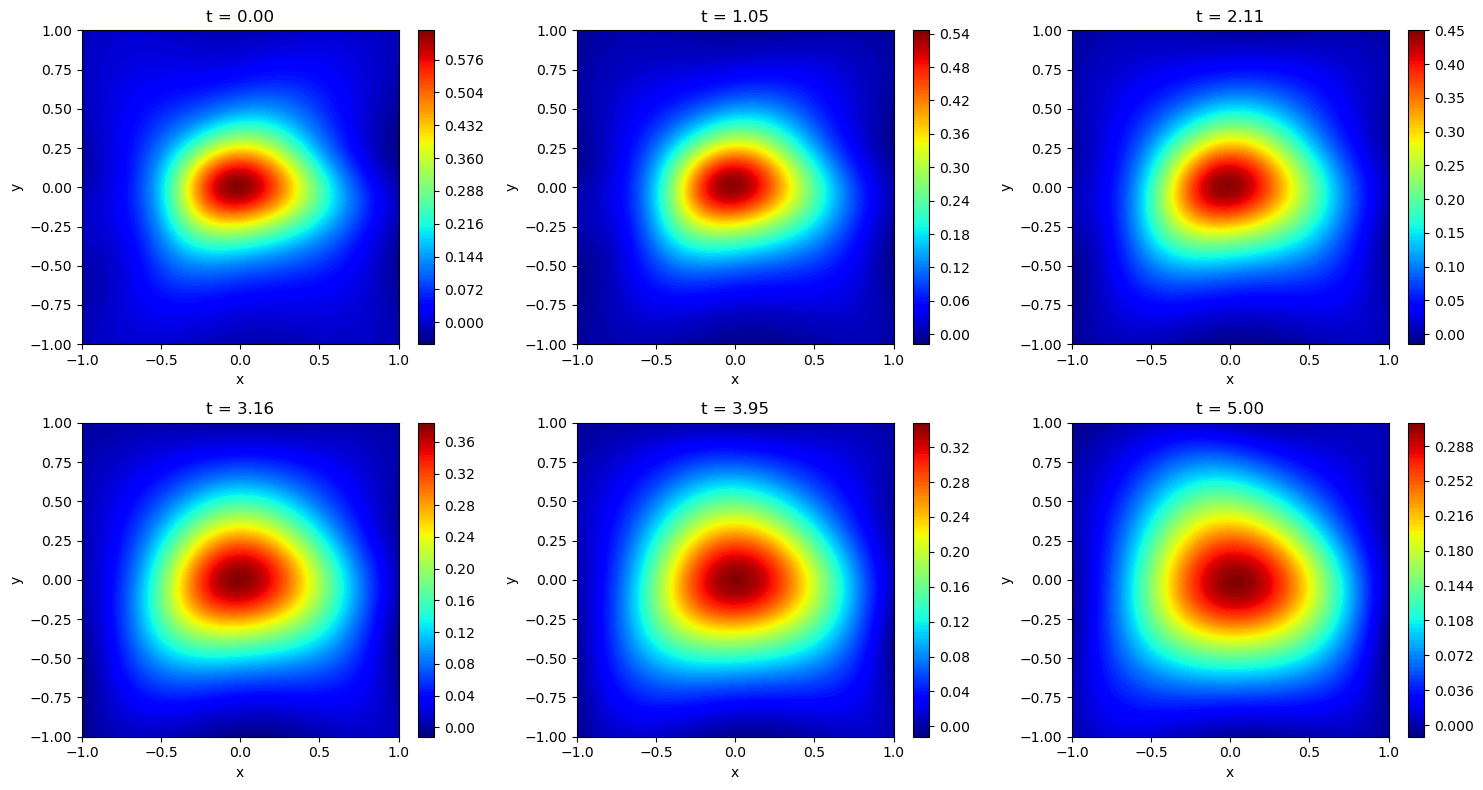

In [20]:
# Visualization at different time points
time_indices = [0, 4, 8, 12, 15, 19]  # Indices for different time points
titles = [f't = {t[i].item():.2f}' for i in time_indices]

plt.figure(figsize=(15, 8))
for i, idx in enumerate(time_indices):
    plt.subplot(2, 3, i+1)
    plt.contourf(x, y, u_pred[:, :, idx].T, levels=100, cmap='jet')
    plt.colorbar()
    plt.title(titles[i])
    plt.xlabel('x')
    plt.ylabel('y')
plt.tight_layout()
plt.show()

In [3]:
# Animation of solution evolution
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Initial frame
cax = ax.contourf(x, y, u_pred[:, :, 0].T, levels=20, cmap='jet')
cb = fig.colorbar(cax)
ax.set_title('2D Heat Equation Solution at t = 0.00')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Define the update function
def update(frame):
    ax.clear()
    cax = ax.contourf(x, y, u_pred[:, :, frame].T, levels=20, cmap='jet')
    ax.set_title(f'2D Heat Equation Solution at t = {t[frame]:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return [cax]  # Return list of Artist objects for blitting

# Create animation
ani = FuncAnimation(fig, update, frames=len(t), interval=200, blit=True)
plt.close()  # Prevents duplicate static plot display in Jupyter

# Display the animation
HTML(ani.to_jshtml())

In [4]:
x = torch.tensor([0.0])
y = torch.tensor([0.0])
t = torch.tensor([0.26])
u = pinn.predict(x, y, t)
print(u)


[[[0.9056694]]]


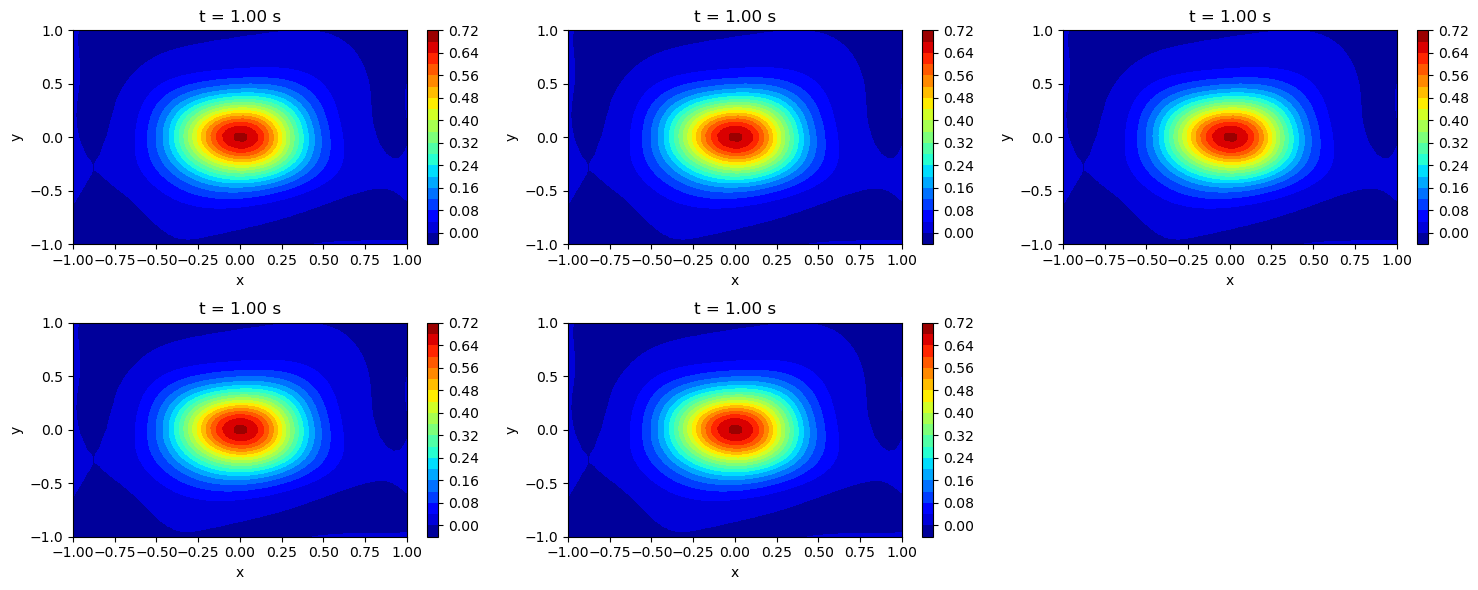

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Convert t to CPU numpy array for indexing (if it's a PyTorch tensor on GPU)
t_np = t.cpu().numpy() if hasattr(t, 'cpu') else t

# Target times in seconds
target_times = [1, 2, 3, 4, 5]

# Find nearest indices for each time value
time_indices = [np.argmin(np.abs(t_np - sec)) for sec in target_times]
titles = [f't = {t_np[i]:.2f} s' for i in time_indices]

# Plotting
plt.figure(figsize=(15, 6))
for i, idx in enumerate(time_indices):
    plt.subplot(2, 3, i + 1)
    plt.contourf(x, y, u_pred[:, :, idx].T, levels=20, cmap='jet')
    plt.colorbar()
    plt.title(titles[i])
    plt.xlabel('x')
    plt.ylabel('y')

plt.tight_layout()
plt.show()
